In [ ]:
# TOBIT 
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("/Users/tobitlouis/Downloads/S27FE-10K.csv")

# Split features and target
X = df.drop('realized_volatility', axis=1).values
y = df['realized_volatility'].values
# y = realized_vol_lookahead(df['log_return'], future_window=100)

y = np.log1p(y)
# Normalize the target variable with log transformation

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape into sliding windows (e.g.,  time steps per sample)
def create_windows(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])  # predict next volatility
    return np.array(Xs), np.array(ys)

window_size = 60
X_seq, y_seq = create_windows(X, y, window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)


In [77]:
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Set batch size here
batch_size = 256

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [78]:
import torch
import torch.nn as nn

class VolatilityCNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()

        # 1st Conv layer: input features → 64
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(64)

        # 2nd Conv layer: 64 → 128
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(128)

        # 3rd Conv layer: 128 → 256
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(256)

        # 4th Conv layer: 256 → 512
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(512)

        # Adaptive pooling to reduce sequence to 1
        self.pool = nn.AdaptiveMaxPool1d(1)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Fully connected output layer
        self.fc = nn.Linear(512, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # → (batch, features, time)

        x = torch.relu(self.bn1(self.conv1(x)))  # → (batch, 64, time')
        x = torch.relu(self.bn2(self.conv2(x)))  # → (batch, 128, time'')
        x = torch.relu(self.bn3(self.conv3(x)))  # → (batch, 256, time''')
        x = torch.relu(self.bn4(self.conv4(x)))  # → (batch, 512, time'''')

        x = self.pool(x)                         # → (batch, 512, 1)
        x = x.view(x.size(0), -1)                # → (batch, 512)
        x = self.dropout(x)
        out = self.fc(x)                         # → (batch, 1)

        return out.squeeze()                     # Final shape: (batch,)


In [79]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001)

# StepLR reduces LR by gamma every step_size epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [80]:
for epoch in range(100):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

    # Adjust the learning rate
    scheduler.step()

    # Optional: show current LR
    current_lr = scheduler.get_last_lr()[0]
    print(f"Learning rate: {current_lr:.6f}")



Epoch 1, Loss: 0.0001
Learning rate: 0.001000
Epoch 2, Loss: 0.0000
Learning rate: 0.001000
Epoch 3, Loss: 0.0000
Learning rate: 0.001000
Epoch 4, Loss: 0.0000
Learning rate: 0.001000
Epoch 5, Loss: 0.0000
Learning rate: 0.001000
Epoch 6, Loss: 0.0000
Learning rate: 0.001000
Epoch 7, Loss: 0.0000
Learning rate: 0.001000
Epoch 8, Loss: 0.0000
Learning rate: 0.001000
Epoch 9, Loss: 0.0000
Learning rate: 0.001000
Epoch 10, Loss: 0.0000
Learning rate: 0.000500
Epoch 11, Loss: 0.0000
Learning rate: 0.000500
Epoch 12, Loss: 0.0000
Learning rate: 0.000500
Epoch 13, Loss: 0.0000
Learning rate: 0.000500
Epoch 14, Loss: 0.0000
Learning rate: 0.000500
Epoch 15, Loss: 0.0000
Learning rate: 0.000500
Epoch 16, Loss: 0.0000
Learning rate: 0.000500
Epoch 17, Loss: 0.0000
Learning rate: 0.000500
Epoch 18, Loss: 0.0000
Learning rate: 0.000500
Epoch 19, Loss: 0.0000
Learning rate: 0.000500
Epoch 20, Loss: 0.0000
Learning rate: 0.000250
Epoch 21, Loss: 0.0000
Learning rate: 0.000250
Epoch 22, Loss: 0.0000

In [81]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

model.eval()
with torch.no_grad():
    y_preds_log = []
    y_trues_log = []
    
    for X_batch, y_batch in test_loader:
        y_pred_log = model(X_batch)  # model outputs log1p(y)
        y_preds_log.append(y_pred_log.numpy())
        y_trues_log.append(y_batch.numpy())  # y_batch should also be log1p(y)

# Concatenate predictions and true values
y_preds_log = np.concatenate(y_preds_log)
y_trues_log = np.concatenate(y_trues_log)

# Invert the log1p transformation
y_preds = np.expm1(y_preds_log)
y_trues = np.expm1(y_trues_log)

# Evaluate in original scale
print(f"MSE: {mean_squared_error(y_trues, y_preds):.4f}")
print(f"R^2: {r2_score(y_trues, y_preds):.4f}")



MSE: 0.0000
R^2: 0.2294


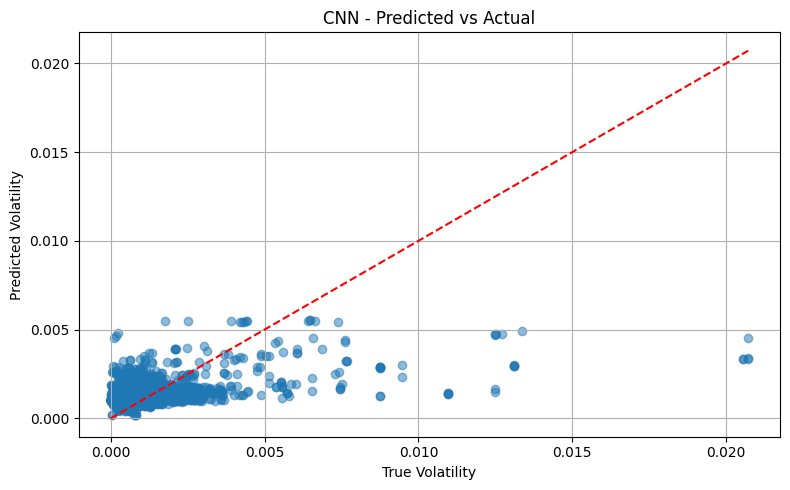

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_trues, y_preds, alpha=0.5)
plt.plot([y_trues.min(), y_trues.max()], [y_trues.min(), y_trues.max()], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("CNN - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


(array([1849., 2968., 1942.,  998.,  643.,  444.,  331.,  137.,  110.,
          75.,   55.,   64.,   31.,   67.,   33.,   31.,    4.,   37.,
          41.,    0.,    0.,   20.,   20.,    0.,    0.,    0.,   20.,
           0.,    0.,    0.,   20.,   20.,   20.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,   20.]),
 array([0.        , 0.00041006, 0.00082012, 0.00123018, 0.00164025,
        0.00205031, 0.00246037, 0.00287043, 0.00328049, 0.00369055,
        0.00410061, 0.00451068, 0.00492074, 0.0053308 , 0.00574086,
        0.00615092, 0.00656098, 0.00697104, 0.00738111, 0.00779117,
        0.00820123, 0.00861129, 0.00902135, 0.00943141, 0.00984147,
        0.01025154, 0.0106616 , 0.01107166, 0.01148172, 0.01189178,
        0.01230184, 0.0127119 , 0.01312197, 0.01353203, 0.01394209,
        0.01435215, 0.01476221, 0.01517227, 0.01558233, 0.0159924 ,
        0.01640246, 0.01681252, 0.01722258, 0.01763264, 

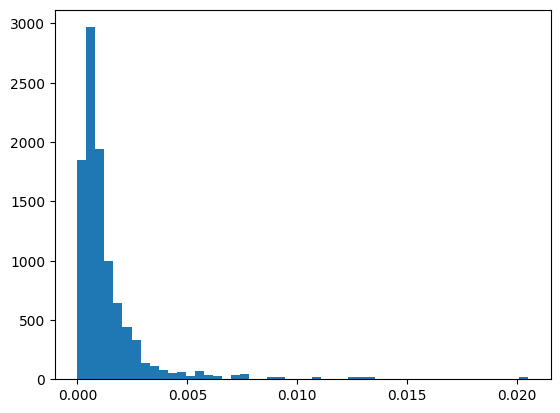

In [83]:
plt.hist(y, bins=50)
